### Notebook
- Creates Figure S2: The cumulative number of driver mutations pan-cancer per cohort

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
from matplotlib import gridspec 
import seaborn as sns
sns.set_style('white')
%matplotlib inline

### 0. Global variables

In [2]:
MSS = 'MSS_only' # MSS_only, MSS_and_MSI

mss_patients = np.loadtxt('../data/mss_tcga_patients.txt', dtype=str)

### 1. Load data

##### 1A. Load patients

In [3]:
# Remove sex-specific cancers for sex-specific analyses
print('Loading confident {} patients with removed sex-specific cancers '.format(MSS))
confident_patients_I_rm_sex_specific = pd.read_csv('../generated_data/confident_patient_I.age_sex_disease.{}.remove_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)
confident_patients_II_rm_sex_specific = pd.read_csv('../generated_data/confident_patient_II.age_sex_disease.{}.remove_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)

print('{} confident MHC-I, {} confident MHC-II'.format(len(set(confident_patients_I_rm_sex_specific.index)), 
                                                       len(set(confident_patients_II_rm_sex_specific.index))))
confident_patients_I_rm_sex_specific.head(2)

Loading confident MSS_only patients with removed sex-specific cancers 
2554 confident MHC-I, 2681 confident MHC-II


,scores,disease,age,sex
TCGA-85-8580,0.120879,LUSC,52.0,female
TCGA-IB-AAUM,1.249676,PAAD,76.0,male


In [4]:
# Keep sex-specific cancers for age-specific analyses
print('Loading confident {} patients with kept sex-specific cancers'.format(MSS))
confident_patients_I_kept_sex_specific = pd.read_csv('../generated_data/confident_patient_I.age_sex_disease.{}.kept_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)
confident_patients_II_kept_sex_specific = pd.read_csv('../generated_data/confident_patient_II.age_sex_disease.{}.kept_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)

# set age threshold
young_thresh = 52 # 30th percentile: 52, 40th: 57
old_thresh = 68-1   # 70th percentile: 68, 60th: 65

# create categorical age value
confident_patients_I_kept_sex_specific['age_categorical_3070'] = pd.cut(confident_patients_I_kept_sex_specific['age'], [0, young_thresh, old_thresh, confident_patients_I_kept_sex_specific['age'].max()], labels=['younger', 'middle', 'older'])
confident_patients_II_kept_sex_specific['age_categorical_3070'] = pd.cut(confident_patients_II_kept_sex_specific['age'], [0, young_thresh, old_thresh, confident_patients_II_kept_sex_specific['age'].max()], labels=['younger', 'middle', 'older'])

confident_patients_I_kept_sex_specific = confident_patients_I_kept_sex_specific[confident_patients_I_kept_sex_specific['age_categorical_3070']!='middle']
confident_patients_II_kept_sex_specific = confident_patients_II_kept_sex_specific[confident_patients_II_kept_sex_specific['age_categorical_3070']!='middle']

print('{} confident MHC-I, {} confident MHC-II'.format(len(set(confident_patients_I_kept_sex_specific.index)), 
                                                       len(set(confident_patients_II_kept_sex_specific.index))))
confident_patients_I_kept_sex_specific.head(2)

Loading confident MSS_only patients with kept sex-specific cancers
1968 confident MHC-I, 1917 confident MHC-II


,scores,disease,age,sex,age_categorical_3070
TCGA-85-8580,0.120879,LUSC,52.0,female,younger
TCGA-IB-AAUM,1.249676,PAAD,76.0,male,older


##### 1B. Load mutation data
- Subset to sex-specific patients or not, for the sex and age analyses, respectively

In [5]:
# sex analysis
binary_mut_I_sex_df = pd.read_csv('../data/patient_binary_driver.expressed_only.matrix', sep='\t', index_col=0)
binary_mut_I_sex_df = binary_mut_I_sex_df[binary_mut_I_sex_df.index.isin(confident_patients_I_rm_sex_specific.index)]

binary_mut_II_sex_df = pd.read_csv('../data/patient_binary_driver.expressed_only.matrix', sep='\t', index_col=0)
binary_mut_II_sex_df = binary_mut_II_sex_df[binary_mut_II_sex_df.index.isin(confident_patients_II_rm_sex_specific.index)]

In [6]:
# age analysis
binary_mut_I_age_df = pd.read_csv('../data/patient_binary_driver.expressed_only.matrix', sep='\t', index_col=0)
binary_mut_I_age_df = binary_mut_I_age_df[binary_mut_I_age_df.index.isin(confident_patients_I_kept_sex_specific.index)]

binary_mut_II_age_df = pd.read_csv('../data/patient_binary_driver.expressed_only.matrix', sep='\t', index_col=0)
binary_mut_II_age_df = binary_mut_II_age_df[binary_mut_II_age_df.index.isin(confident_patients_II_kept_sex_specific.index)]

###### 1Ba. How many patients have 0?

In [7]:
zero_I_sex_df = pd.read_csv('../data/patient_binary_driver.expressed_only.matrix', sep='\t', index_col=0)
print(zero_I_sex_df.shape)
zero_I_sex_df = zero_I_sex_df.sum(axis=1)
zero_I_sex_df = zero_I_sex_df[zero_I_sex_df==0]
zero_I_sex_df

(9727, 1017)


TCGA-X2-A95T    0
TCGA-G7-6793    0
TCGA-FW-A3I3    0
TCGA-VS-A8QF    0
TCGA-98-A539    0
               ..
TCGA-CH-5739    0
TCGA-S9-A6WM    0
TCGA-DD-AAD1    0
TCGA-YG-AA3P    0
TCGA-2G-AAGE    0
Length: 4360, dtype: int64

##### 1C. Subset to male/female and younger/older patients
- Total sum first

In [8]:
# sex
female_I = binary_mut_I_sex_df[binary_mut_I_sex_df.index.isin(confident_patients_I_rm_sex_specific[confident_patients_I_rm_sex_specific['sex']=='female'].index)].sum(axis=1) 
male_I = binary_mut_I_sex_df[binary_mut_I_sex_df.index.isin(confident_patients_I_rm_sex_specific[confident_patients_I_rm_sex_specific['sex']=='male'].index)].sum(axis=1) 

female_II = binary_mut_II_sex_df[binary_mut_II_sex_df.index.isin(confident_patients_II_rm_sex_specific[confident_patients_II_rm_sex_specific['sex']=='female'].index)].sum(axis=1) 
male_II = binary_mut_II_sex_df[binary_mut_II_sex_df.index.isin(confident_patients_II_rm_sex_specific[confident_patients_II_rm_sex_specific['sex']=='male'].index)].sum(axis=1) 

# age  
younger_I = binary_mut_I_age_df[binary_mut_I_age_df.index.isin(confident_patients_I_kept_sex_specific[confident_patients_I_kept_sex_specific['age_categorical_3070']=='younger'].index)].sum(axis=1)
older_I = binary_mut_I_age_df[binary_mut_I_age_df.index.isin(confident_patients_I_kept_sex_specific[confident_patients_I_kept_sex_specific['age_categorical_3070']=='older'].index)].sum(axis=1)

younger_II = binary_mut_II_age_df[binary_mut_II_age_df.index.isin(confident_patients_II_kept_sex_specific[confident_patients_II_kept_sex_specific['age_categorical_3070']=='younger'].index)].sum(axis=1)
older_II = binary_mut_II_age_df[binary_mut_II_age_df.index.isin(confident_patients_II_kept_sex_specific[confident_patients_II_kept_sex_specific['age_categorical_3070']=='older'].index)].sum(axis=1)

In [9]:
def make_ECDF_and_compare(one, two, one_category_string, two_category_string, one_color, two_color,
                          savepath):
    # prep, consolidate
    one = pd.DataFrame(one, columns=['num_drivers'])
    one['category'] = one_category_string
    
    two = pd.DataFrame(two, columns=['num_drivers'])
    two['category'] = two_category_string
    
    df = one.append(two)
    
    # ECDF & p-value
    one_ecdf = ECDF(df[df['category']==one_category_string]['num_drivers'].values)
    two_ecdf = ECDF(df[df['category']==two_category_string]['num_drivers'].values)

    ks, p = ks_2samp(one_ecdf.y, two_ecdf.y)
    
    # plot
    plt.figure(figsize=(4,3))
    plt.plot(one_ecdf.x, one_ecdf.y, label=one_category_string, color=one_color)
    plt.plot(two_ecdf.x, two_ecdf.y, label=two_category_string, color=two_color)
    plt.text(14,0.25,'KS: {:.2}\np<{:.3}'.format(ks, p))
    print(ks, p)
    plt.xlim(0,20)
    plt.legend()
    print('Saving to {}'.format(savepath))
    plt.savefig(savepath)
    plt.show()

0.0009227611034706706 1.0
Saving to ../figures/S2.num_drivers.sex_I.ecdf.pdf


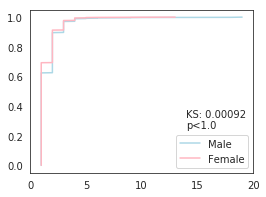

0.0008949825828806768 1.0
Saving to ../figures/S2.num_drivers.sex_II.ecdf.pdf


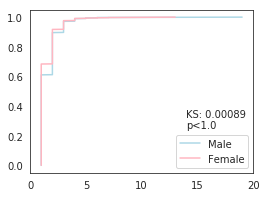

0.0010397744679665928 1.0
Saving to ../figures/S2.num_drivers.age_I.ecdf.pdf


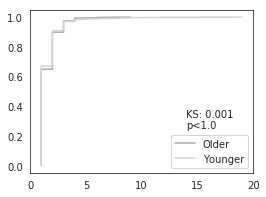

0.001044988833175442 1.0
Saving to ../figures/S2.num_drivers.age_II.ecdf.pdf


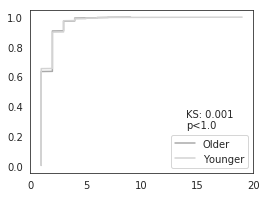

In [10]:
make_ECDF_and_compare(male_I, female_I, 'Male', 'Female', 'lightblue', 'lightpink', 
                      savepath='../figures/S2.num_drivers.sex_I.ecdf.pdf')
make_ECDF_and_compare(male_II, female_II, 'Male', 'Female', 'lightblue', 'lightpink', 
                      savepath='../figures/S2.num_drivers.sex_II.ecdf.pdf')
make_ECDF_and_compare(older_I, younger_I, 'Older', 'Younger', 'darkgrey', 'lightgrey', 
                      savepath='../figures/S2.num_drivers.age_I.ecdf.pdf')
make_ECDF_and_compare(older_II, younger_II, 'Older', 'Younger', 'darkgrey', 'lightgrey', 
                      savepath='../figures/S2.num_drivers.age_II.ecdf.pdf')